In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
from matplotlib_venn import venn3, venn3_circles
import numpy as np
from tqdm import tqdm


In [422]:
PATH_TO_TRAIN_CSV = '/algo/users/marc/kaggle_pe/train.csv'
PATH_TO_DCM_DIR = '/algo/users/marc/kaggle_pe/data/train'
PATH_TO_MERGED_CSV = '/algo/users/marc/kaggle_pe/merged_train.csv'

In [97]:
pip install matplotlib-venn

Looking in indexes: https://pypi.python.org, http://nexus.zebra-med.com/repository/pypi/simple
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=35232 sha256=c4f6563327abee656920296c16be688fbb3ca37665f4ca38b6e4f297d7f88401
  Stored in directory: /home/marc/.cache/pip/wheels/e6/6a/7e/01333d08730e0557a60f4e2869078e3449f418f2a61f349c23
Successfully built matplotlib-venn
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [345]:
df = pd.read_csv('/algo/users/marc/kaggle_pe/train.csv')

# Quick Sanity Checks

In [52]:
df.groupby('StudyInstanceUID')['SeriesInstanceUID'].unique().apply(lambda x: len(x)).value_counts()

1    7279
Name: SeriesInstanceUID, dtype: int64

Every Study Contains a Single Series

In [53]:
for column in df.columns:
    if 'UID' not in column:
        std = df.groupby('SeriesInstanceUID')[column].std().max()
        print("{}: {}".format(column,std))

pe_present_on_image: 0.5014068682843242
negative_exam_for_pe: 0.0
qa_motion: 0.0
qa_contrast: 0.0
flow_artifact: 0.0
rv_lv_ratio_gte_1: 0.0
rv_lv_ratio_lt_1: 0.0
leftsided_pe: 0.0
chronic_pe: 0.0
true_filling_defect_not_pe: 0.0
rightsided_pe: 0.0
acute_and_chronic_pe: 0.0
central_pe: 0.0
indeterminate: 0.0


<font color='green'>All labels are Series Level except "pe_present_on_image"</font>

# Series Level Analysis

In [54]:
series_level_df = df.sort_values(by='pe_present_on_image',ascending=False)
series_level_df = series_level_df.drop_duplicates(subset=['SeriesInstanceUID'])

In [55]:
series_level_df.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

In [72]:
series_level_df.groupby(['qa_contrast','qa_motion'])['indeterminate'].value_counts()

qa_contrast  qa_motion  indeterminate
0            0          0                7122
             1          1                  35
1            0          1                  94
             1          1                  28
Name: indeterminate, dtype: int64

In [75]:
for column in series_level_df.columns:
    if 'UID' not in column:
        print(series_level_df.groupby('indeterminate')[column].value_counts(normalize=True))

indeterminate  pe_present_on_image
0              0                      0.689553
               1                      0.310447
1              0                      1.000000
Name: pe_present_on_image, dtype: float64
indeterminate  negative_exam_for_pe
0              1                       0.689553
               0                       0.310447
1              0                       1.000000
Name: negative_exam_for_pe, dtype: float64
indeterminate  qa_motion
0              0            1.000000
1              0            0.598726
               1            0.401274
Name: qa_motion, dtype: float64
indeterminate  qa_contrast
0              0              1.00000
1              1              0.77707
               0              0.22293
Name: qa_contrast, dtype: float64
indeterminate  flow_artifact
0              0                0.960826
               1                0.039174
1              0                0.898089
               1                0.101911
Name: flow_artifact, dt

<font color='green'> Flow Artifact (as well as qa_motion and qa_contrast) is the only field filled in with indeterminates <font>

In [76]:
series_level_df.groupby('negative_exam_for_pe')['pe_present_on_image'].value_counts()

negative_exam_for_pe  pe_present_on_image
0                     1                      2211
                      0                       157
1                     0                      4911
Name: pe_present_on_image, dtype: int64

<font color='green'> Indeterminates are labeled as negative_exam_for_pe=0 <font>

In [77]:
determinate_df = series_level_df[series_level_df['indeterminate']==0]

In [78]:
SUB_CATS = ['flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe']

In [79]:
for cat in SUB_CATS:
    print(series_level_df.groupby('pe_present_on_image')[cat].value_counts(normalize=True))

pe_present_on_image  flow_artifact
0                    0                0.955012
                     1                0.044988
1                    0                0.969697
                     1                0.030303
Name: flow_artifact, dtype: float64
pe_present_on_image  rv_lv_ratio_gte_1
0                    0                    1.000000
1                    0                    0.574853
                     1                    0.425147
Name: rv_lv_ratio_gte_1, dtype: float64
pe_present_on_image  rv_lv_ratio_lt_1
0                    0                   1.000000
1                    1                   0.574853
                     0                   0.425147
Name: rv_lv_ratio_lt_1, dtype: float64
pe_present_on_image  leftsided_pe
0                    0               1.000000
1                    1               0.698327
                     0               0.301673
Name: leftsided_pe, dtype: float64
pe_present_on_image  chronic_pe
0                    0             1.000000

<font color='green'> A few notes: <font>
     - LV/RV Ratio only Given for PE Positive Cases 
     - True Filling Defect more likely in PE Positive (perhaps reporting differences)
     - Flow Artifact More Likely in PE Negative (perhaps reporting differences)


In [111]:
pe_positive_df = determinate_df[determinate_df['pe_present_on_image']==1]

In [86]:
pe_positive_df['rv_lv_ratio_gte_1'].value_counts(normalize=True)

0    0.574853
1    0.425147
Name: rv_lv_ratio_gte_1, dtype: float64

In [87]:
pe_positive_df['leftsided_pe'].value_counts(normalize=True)

1    0.698327
0    0.301673
Name: leftsided_pe, dtype: float64

In [88]:
pe_positive_df['rightsided_pe'].value_counts(normalize=True)

1    0.848033
0    0.151967
Name: rightsided_pe, dtype: float64

In [89]:
pe_positive_df['central_pe'].value_counts(normalize=True)

0    0.818634
1    0.181366
Name: central_pe, dtype: float64

In [96]:
pe_positive_df.groupby(['leftsided_pe'])['rightsided_pe'].value_counts(normalize=False)

leftsided_pe  rightsided_pe
0             1                 663
              0                   4
1             1                1212
              0                 332
Name: rightsided_pe, dtype: int64

In [94]:
pe_positive_df.groupby(['leftsided_pe','rightsided_pe'])['central_pe'].value_counts(normalize=False)

leftsided_pe  rightsided_pe  central_pe
0             0              1               4
              1              0             627
                             1              36
1             0              0             317
                             1              15
              1              0             866
                             1             346
Name: central_pe, dtype: int64

<font color='green'> Given Left-sided PE, likely also Rightsided <font>

In [118]:
left = pe_positive_df[pe_positive_df['leftsided_pe']==1]['SeriesInstanceUID'].values
right= pe_positive_df[pe_positive_df['rightsided_pe']==1]['SeriesInstanceUID'].values
center= pe_positive_df[pe_positive_df['central_pe']==1]['SeriesInstanceUID'].values

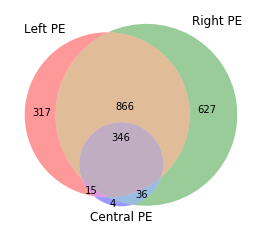

In [119]:
venn3([set(left), set(right), set(center)],set_labels=['Left PE', 'Right PE','Central PE'])
plt.title('PE by Side')
plt.show()

In [123]:
left_rv_lv = pe_positive_df[(pe_positive_df['leftsided_pe']==1) & (pe_positive_df['rv_lv_ratio_gte_1']==1) ]['SeriesInstanceUID'].values
right_rv_lv = pe_positive_df[(pe_positive_df['rightsided_pe']==1) & ((pe_positive_df['rv_lv_ratio_gte_1']==1))]['SeriesInstanceUID'].values
center_rv_lv = pe_positive_df[(pe_positive_df['central_pe']==1) & ((pe_positive_df['rv_lv_ratio_gte_1']==1))]['SeriesInstanceUID'].values

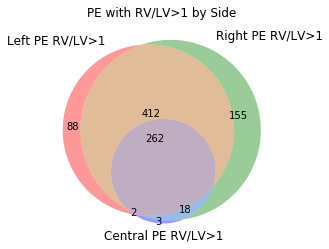

In [126]:
venn3([set(left_rv_lv), set(right_rv_lv), set(center_rv_lv)],set_labels=['Left PE RV/LV>1', 'Right PE RV/LV>1','Central PE RV/LV>1'])
plt.title('PE with RV/LV>1 by Side')
plt.show()

In [127]:
pe_positive_df.groupby(['chronic_pe'])['acute_and_chronic_pe'].value_counts()

chronic_pe  acute_and_chronic_pe
0           0                       1774
            1                        145
1           0                        292
Name: acute_and_chronic_pe, dtype: int64

# Slice Level Analysis

In [293]:
determinate_df = df[df['indeterminate']==0]

In [301]:
determinate_df.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

In [303]:
pe_pos_df = determinate_df[determinate_df['negative_exam_for_pe']==0]
pe_neg_df = determinate_df[determinate_df['negative_exam_for_pe']==1]

In [319]:
pe_pos_df.groupby('SeriesInstanceUID')['SOPInstanceUID'].count().mean()

245.48575305291723

In [320]:
pe_neg_df.groupby('SeriesInstanceUID')['SOPInstanceUID'].count().mean()

246.6188149053146

In [322]:
num_pos_series = len(pe_pos_df['SeriesInstanceUID'].unique())

In [330]:
neg_series_selected = np.random.choice(pe_neg_df['SeriesInstanceUID'].unique(),size=num_pos_series,replace=False)
pe_neg_df_selected = pe_neg_df[pe_neg_df['SeriesInstanceUID'].isin(neg_series_selected)]

Text(0.5, 1.0, 'Slices per Series')

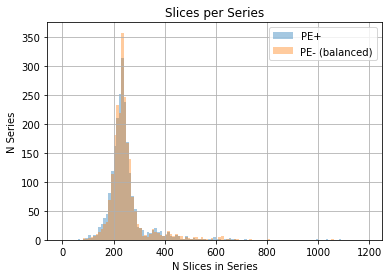

In [332]:
pe_pos_df.groupby('SeriesInstanceUID')['SOPInstanceUID'].count().hist(bins=np.arange(0,1200,10),alpha=0.4,label = 'PE+')
pe_neg_df_selected.groupby('SeriesInstanceUID')['SOPInstanceUID'].count().hist(bins=np.arange(0,1200,10),alpha=0.4,label = 'PE- (balanced)')

plt.legend()
plt.xlabel('N Slices in Series')
plt.ylabel('N Series')
plt.title('Slices per Series')

In [334]:
pe_positive_df.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

Text(0, 0.5, 'Number Series')

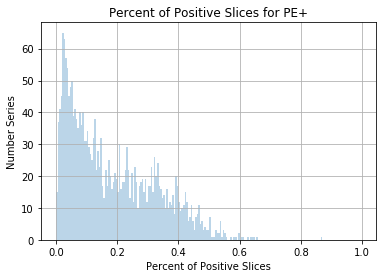

In [342]:
pos_slices_percent = pe_pos_df.groupby('SeriesInstanceUID')['pe_present_on_image'].mean()
pos_slices_percent.hist(bins=np.arange(0,1,0.005),alpha=0.3)
plt.title('Percent of Positive Slices for PE+')
plt.xlabel('Percent of Positive Slices')
plt.ylabel('Number Series')

# Display Slices

In [533]:
def get_ordered_dicoms(df,study_id, path_to_dcm_dir):
    study_df = df[df['StudyInstanceUID']==study_id]
    series_id = study_df.iloc[0]['SeriesInstanceUID']
    dcm_base_path = os.path.join(path_to_dcm_dir, study_id, series_id)
    dcms = [pydicom.dcmread(os.path.join(dcm_base_path, dcm_id + '.dcm')) for dcm_id in
            study_df['SOPInstanceUID']]
    instance_number_array = [(int(dcm['InstanceNumber'].value), dcm) for dcm in dcms]
    sorted_array = [x[1] for x in sorted(instance_number_array)]
    return sorted_array

In [517]:
STUDY_INSTANCE_UID

'5a7be944da6d'

10it [00:00, 558.06it/s]


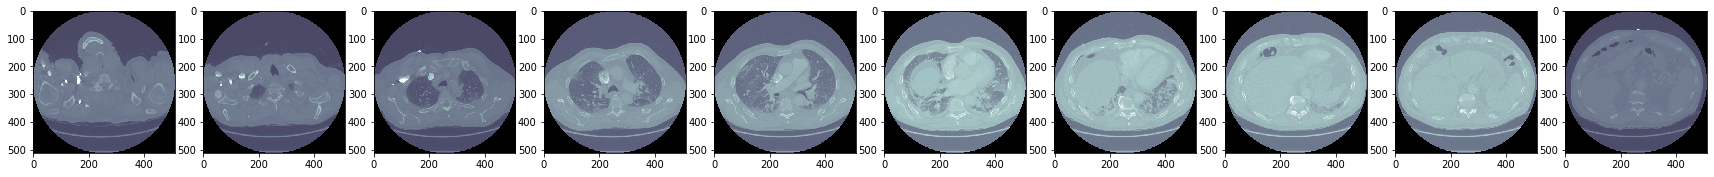

In [540]:
NUM_ROWS = 10
STUDY_INSTANCE_UID = '5a7be944da6d'
sorted_array = get_ordered_dicoms(pe_pos_df,STUDY_INSTANCE_UID,PATH_TO_DCM_DIR)
image_array = [dcm.pixel_array for dcm in sorted_array]

fig,ax = plt.subplots(1,NUM_ROWS)
fig.set_size_inches(30,3)

for plot_index, dcm_index in tqdm(enumerate(np.linspace(0,len(image_array)-1,NUM_ROWS).astype(int))):
    ax[plot_index].imshow(image_array[dcm_index],plt.cm.bone)


In [516]:
def get_first_slice_last_slice():
    dcms = [pydicom.dcmread(os.path.join(dcm_base_path,dcm_id + '.dcm')) for dcm_id in sample_series_df['SOPInstanceUID']]


In [362]:
first_pe_slice = pe_pos_df.groupby('SeriesInstanceUID').apply(lambda x: np.argmax(x['pe_present_on_image'])/ len(x))
last_pe_slice = pe_pos_df.groupby('SeriesInstanceUID').apply(lambda x: np.argwhere(x['pe_present_on_image'].values)[-1][0]/ len(x))
#median_pe_slice = pe_pos_df.groupby('SeriesInstanceUID').apply(lambda x: np.argmax(x['pe_present_on_image'])/ len(x))

Text(0.5, 1.0, 'Where are the first and last slices with PE?')

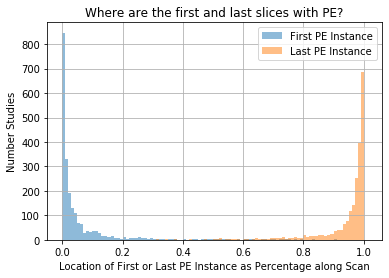

In [408]:
first_pe_slice.hist(bins=np.arange(0,1.02,0.01),alpha=0.5,label="First PE Instance")
last_pe_slice.hist(bins=np.arange(0,1.02,0.01),alpha=0.5, label = 'Last PE Instance')
plt.legend()
plt.xlabel('Location of First or Last PE Instance as Percentage along Scan')
plt.ylabel('Number Studies')
plt.title('Where are the first and last slices with PE?')

In [ ]:
percent slices.
first, last, median 

# DCM Metadata Analysis

In [291]:
dcm = pydicom.dcmread("/algo/users/marc/kaggle_pe/00ac73cfc372.dcm")

In [292]:
dcm

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 00ac73cfc372
(0008, 0060) Modality                            CS: 'CT'
(0009, 0010) Private Creator                     LO: 'GEMS_IDEN_01'
(0009, 0011) Private Creator                     LO: 'GEIIS'
(0018, 0050) Slice Thickness                     DS: "1.250000"
(0018, 0060) KVP                                 DS: "140"
(0018, 1120) Gantry/Detector Tilt                DS: "0.000000"
(0018, 1130) Table Height                        DS: "203.000000"
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: "663"
(0018, 1152) Exposure                            IS: "7"
(0018, 1210) Convolution Kernel                  SH: 'STANDARD'
(0018, 5100) Patient Position         

In [507]:
merged_df = pd.read_csv('/algo/users/marc/kaggle_pe/merged_train.csv')
merged_df['pe_positive_series'] = 1 - merged_df['negative_exam_for_pe']

Text(0, 0.5, 'Number Series')

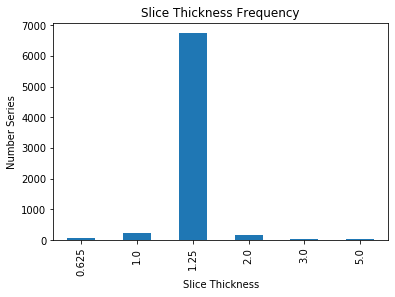

In [509]:
merged_df['Slice Thickness'].value_counts().sort_index().plot.bar()
plt.title('Slice Thickness Frequency')
plt.xlabel('Slice Thickness')
plt.ylabel('Number Series')

Text(0, 0.5, 'Percent PE Positive')

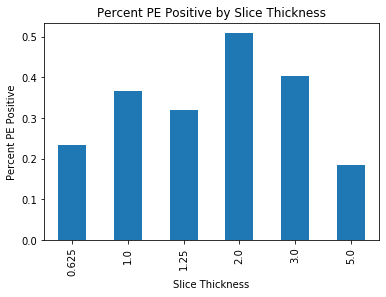

In [514]:
merged_df.groupby('Slice Thickness')['pe_positive_series'].mean().plot.bar()
plt.title('Percent PE Positive by Slice Thickness')
plt.xlabel('Slice Thickness')
plt.ylabel('Percent PE Positive')

Text(0, 0.5, 'Number Series')

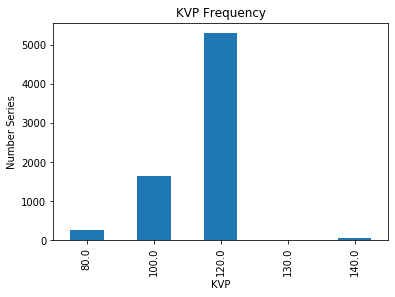

In [511]:
merged_df['KVP'].value_counts().sort_index().plot.bar()
plt.title('KVP Frequency')
plt.xlabel('KVP')
plt.ylabel('Number Series')

Text(0, 0.5, 'Percent PE Positive')

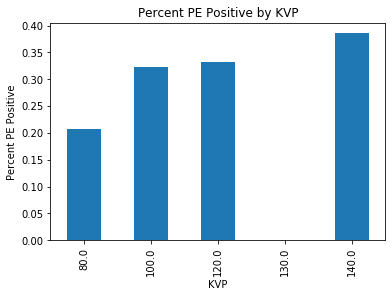

In [513]:
merged_df.groupby('KVP')['pe_positive_series'].mean().plot.bar()
plt.title('Percent PE Positive by KVP')
plt.xlabel('KVP')
plt.ylabel('Percent PE Positive')

<font color='green'> Conclusion: We do not want to do any manual balancing since both dicoms are overwhelmingly of one class, but since the prevalence is very different for KVP!=120 and Slice Thickness != 1.25 we should check performance on these sets manually <font>